In [1]:
# import os
import SunStatistics as SS
from scipy.stats import pearsonr
%matplotlib notebook
# import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta,datetime
import pytz

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

G_Drive = 'G:\\My Drive\\'
G_Drive = 'C:\\Users\\User\\Google Drive\\'
Output_Path = G_Drive+'FishIsland_Outputs/'

# Model Functions

In [2]:
def Model_Test_RF(X,y,AllData,K=10,Task = 'Predict',min_samples_split=None,Verbose=True,random_state=1):
    Data = AllData[X+y].dropna()
    kf = KFold(n_splits=K,shuffle=True, random_state = random_state)
    R2 = []
    MSE = []
    Imp = []    
    Pred = []
    rnd=1
    for train_index, test_index in kf.split(Data):
        df_test = Data.iloc[test_index]
        df_train = Data.iloc[train_index]
        X_train = np.array(df_train[X])#.reshape(-1, 1)     
        y_train = np.array(df_train[y]).ravel()#.reshape(-1, 1)
        X_test = np.array(df_test[X])#.reshape(-1, 1)  
        y_test = np.array(df_test[y]).ravel()#.reshape(-1, 1)
        Mod = RandomForestRegressor(min_samples_split=min_samples_split, random_state=random_state+rnd)#,bootstrap=False)
        rnd+=1
        Mod.fit(X_train, y_train)
        Test = Mod.predict(X_test)
        Pred.append(Mod.predict(AllData[X]))
        R2.append(metrics.r2_score(y_test,Test))
        MSE.append(metrics.mean_squared_error(y_test,Test))
        Imp.append(Mod.feature_importances_)
    Imp = np.mean(np.array(Imp),axis=0)
    Pred = np.mean(np.array(Pred),axis=0)
    if Verbose == True:
        print()
        print(y[0])
        print('RMSE', np.mean(np.array(MSE)**.5))
        print('std RMSE', np.std(np.array(MSE)**.5))
        print('r2', np.median(np.array(R2)))
        print('Imp',np.round(Imp,3)*100)
    if Task == 'Predict':
        return(Pred)
    if Task == 'Predict_Return':
        return(Pred,Imp,MSE,R2)
    elif Task == 'Optimize':
        return(MSE)

def Model_Test_OLS(X,y,AllData,K=10,Task = 'Predict',fit_intercept=None,Scale=False,Verbose=True,random_state=1):
    if Scale==True:
        Mod = make_pipeline(StandardScaler(), LinearRegression(fit_intercept=fit_intercept))
    else:
        Mod = make_pipeline(LinearRegression(fit_intercept=fit_intercept))
    Data = AllData[X+y].dropna()
    kf = KFold(n_splits=K,shuffle=True, random_state = random_state)
    R2 = []
    MSE = []
    Int = []
    Coef = []
    Pred = []
    for train_index, test_index in kf.split(Data):
        df_test = Data.iloc[test_index]
        df_train = Data.iloc[train_index]
        X_train = np.array(df_train[X])#.reshape(-1, 1)     
        y_train = np.array(df_train[y])#.reshape(-1, 1)
        X_test = np.array(df_test[X])#.reshape(-1, 1)  
        y_test = np.array(df_test[y])#.reshape(-1, 1)
        Mod.fit(X_train, y_train)
        Test = Mod.predict(X_test)
        if y == ['VPD'] or y == ['PPFD_Avg']:
            Test[Test<0]=0
        
        R2.append(metrics.r2_score(y_test,Test))
        MSE.append(metrics.mean_squared_error(y_test,Test))
        Pred.append(Mod.predict(AllData[X]))
        Int.append(Mod[-1].intercept_)
        Coef.append(Mod[-1].coef_)
    Coef = np.mean(np.array(Coef),axis=0).mean(axis=0)
    Pred = np.mean(np.array(Pred),axis=0)#.mean(axis=0)
    Int = np.mean(np.array(Int))
    if Verbose == True:
        print()
        print(y[0])
        print('RMSE', np.mean(np.array(MSE)**.5))
        print('std RMSE', np.std(np.array(MSE)**.5))
        print('r2', np.median(np.array(R2)))
        print('coef', Coef)
        print('int',Int)
    if Task == 'Predict':
        return(Pred)#.values)
    if Task == 'Predict_Return':
        return(Pred,Coef,Int,MSE,R2)
    elif Task == 'Optimize':
        return(MSE)
    
def Model_Test(X,y,AllData,K=10,Task = 'Predict',Test = 'OLS',min_samples_split=None,fit_intercept=True,Scale=False,Verbose=True,random_state=1):
    if Test == 'OLS':
        return(Model_Test_OLS(X,y,AllData,K=10,Task = Task,fit_intercept=fit_intercept,Scale=Scale,Verbose=Verbose,random_state=random_state))
    elif Test == 'RF':
        return(Model_Test_RF(X,y,AllData,K=10,Task = Task,min_samples_split=min_samples_split,Verbose=Verbose,random_state=random_state))
    

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues


In [3]:

def get_uv(Dir,U_bar,dec=0):
    M_dir = 270-(Dir+dec)
    U = np.cos(M_dir/180*np.pi)*U_bar
    V = np.sin(M_dir/180*np.pi)*U_bar
    return(U,V)
def get_wDir(u,v,m_dec=0):
    W_dir = np.arctan2(v,u)*180/np.pi
    W_dir = 270 - W_dir    
    W_dir[W_dir>360]-=360
    return(W_dir)

# Data

In [4]:
Taglu_Data = Output_Path+'Taglu_Data/Hourly.csv'
AWS = pd.read_csv(Taglu_Data,
parse_dates={'datetime':['Year','Month','Day','Time']}, 
).set_index('datetime')

# Gap Fill
C=['Air Temp','Net Radiation','Net SW Radiation','Net LW Radiation ','Wind Speed']
s = AWS.index.to_series()
print('Missing')
for c in C:
    print(c,AWS.loc[((AWS.index.month>=4)&(AWS.index.month<=10)),c].isnull().sum())
    miss = AWS[c].isna()
    #create consecutive groups
    g = miss.ne(miss.shift()).cumsum()
    #aggregate minimal 
    m1 = s.groupby(g).min()
    #get minimal of next groups, last value is replaced last value of index
    m2 = m1.shift(-1).fillna(AWS.index[-1])
    #get difference, convert to minutes
    out = m2.sub(m1).dt.total_seconds().div(3600).astype(int)
    AWS['Temp_Gap'] = g.map(out)
    AWS['Temp']=AWS[c].interpolate()
    AWS.loc[AWS['Temp_Gap']<=4,c]=AWS.loc[AWS['Temp_Gap']<=4,'Temp']
    AWS['Temp1']=AWS[c].shift(24)
    AWS['Temp2']=AWS[c].shift(-24)
    AWS.loc[AWS['Temp_Gap']>=4,c].fillna(AWS.loc[AWS['Temp_Gap']>=4,['Temp1','Temp2']].mean(axis=1))
AWS = AWS.drop(columns=['Temp_Gap','Temp','Temp1','Temp2'])
AWS_Rename = {'Air Temp':'Air_Temp',
              'Rainfall':'Rainfall',
              'Wind Speed':'Wind_Speed',
              'Wind direction':'Wind_Direction',
              'Net SW Radiation':'Net_SW',
              'Net LW Radiation ':'Net_LW',
              'Net Radiation':'Net_RN'}
AWS = AWS.rename(columns=AWS_Rename)
AWS_cols = list(AWS_Rename.values())

LAT = 69.371182
LON = -134.880935
TZ = -6

Temp = AWS[['Net_SW']].resample('5T').asfreq()
D = Temp.index.floor('D').to_julian_date()
T = Temp.index.hour/24+Temp.index.minute/60/24
A = np.ones(D.shape[0])

Zenith,Angle,Angle_Corr,Azimuth,Sunrise,Sunset=SS.SunStats(LAT*A,LON*A,D.values,T.values,TZ*A)
Temp['Sun_Angle'] = Angle_Corr
Temp = Temp.resample('30T').mean()

Temp['Daytime_Mask']=0.0
Temp.loc[Temp['Sun_Angle']>-0.5,'Daytime_Mask']=1.0

print(Temp.groupby('Daytime_Mask').count()['Sun_Angle'])
Temp = Temp.resample('H').mean()
print(Temp.groupby('Daytime_Mask').count()['Sun_Angle'])

try:
    AWS = AWS.drop(columns=['Sun_Angle','Daytime_Mask'])
except:
    pass
AWS = AWS.join(Temp[['Sun_Angle','Daytime_Mask']])

AWS['Daytime']=0
AWS.loc[AWS['Sun_Angle']>-0.5,'Daytime']=1


Mt = pytz.timezone('Canada/Mountain')
UTC = AWS.index+timedelta(hours=6)
AWS = AWS.set_index(UTC)
AWS.index = AWS.index.tz_localize(pytz.utc).tz_convert(Mt)

U,V = get_uv(AWS['Wind_Direction'],AWS['Wind_Speed'])
AWS['U_bar_AWS'] = U
AWS['V_bar_AWS'] = V
## 
print('Bad SW Fix',AWS.loc[AWS['Net_SW']<-5,'Net_SW'].count())
AWS.loc[AWS['Net_SW']<-5,'Net_SW']=-5
AWS.loc[AWS['Net_SW']<-5,'Net_RN']=AWS.loc[AWS['Net_SW']<-5,['Net_SW','Net_LW']].sum(axis=1)

AWS.groupby('Daytime').count()['Air_Temp']

Missing
Air Temp 40
Net Radiation 40
Net SW Radiation 40
Net LW Radiation  40
Wind Speed 40


C:\Users\User\FishIsland_Flux_Analysis\FluxProcessing\SunStatistics.py:25: RuntimeWarning: invalid value encountered in arccos
  W2 = np.degrees(np.arccos(np.cos(np.radians(90.833))/(np.cos(np.radians(LAT))*np.cos(np.radians(T2)))-np.tan(np.radians(LAT))*np.tan(np.radians(T2)))) #HA Sunrise (deg)


Daytime_Mask
0.0     99673
1.0    109924
Name: Sun_Angle, dtype: int64
Daytime_Mask
0.0    48317
0.5     3039
1.0    53443
Name: Sun_Angle, dtype: int64
Bad SW Fix 913


Daytime
0    49891
1    54870
Name: Air_Temp, dtype: int64

# EC Data

In [5]:
EC_Data = pd.read_csv(Output_Path+'FI_Footprints_2022-02-23_2000mx2m.csv',delimiter = ',',header = 0,na_values = -9999,
                   index_col=['datetime'],
                  ).drop('Unnamed: 0',axis=1)
EC_Data = EC_Data.set_index(pd.to_datetime(EC_Data.index, utc=True)).tz_convert(Mt)
EC_Data = EC_Data.rename(columns={'Daytime':'Daytime_Raw',
                                 'Sun_Angle':'Sun_Angle_Raw'})

U,V=get_uv(EC_Data['wind_dir'],EC_Data['wind_speed'],dec=-22)
EC_Data['U_bar_EC']=U
EC_Data['V_bar_EC']=V

FSO = pd.read_csv(Output_Path+'Skeeter_et_al_2022_Day_Fix.csv',index_col=['datetime']).drop('Unnamed: 0',axis=1)#.drop('datetime.1',axis=1)

FSO = FSO.set_index(pd.to_datetime(FSO.index, utc=True)).tz_convert(Mt)
FSO = FSO.rename(columns={'NEE_est':'NEE_FSO',
                            'NME_est':'NME_FSO'})
EC_Data = EC_Data.join(FSO[['NEE_FSO',
'NME_FSO']])

kwargs = {'closed':'right','label':'left'}
EC_Data_r=EC_Data.resample('h',**kwargs).mean()
EC_Data_r['Rain_mm_Tot']=EC_Data.resample('h',**kwargs).sum()['Rain_mm_Tot']

EC_Data_r = EC_Data_r.drop(['Wind_Direction', 'Wind_Speed'],axis=1)

EC_Data_r_mask = EC_Data.resample('h',**kwargs).count()[['fco2','fch4']]

EC_Data_r_mask.loc[EC_Data_r_mask['fco2']<2,'fco2']=np.nan
EC_Data_r_mask.loc[EC_Data_r_mask['fch4']<2,'fch4']=np.nan

EC_Data_r_mask/=2
EC_Data_r['fco2']*=EC_Data_r_mask['fco2']
EC_Data_r['fch4']*=EC_Data_r_mask['fch4']

print(EC_Data_r[['fco2','co2_flux','fch4','ch4_flux']].count())

Data_M1 = EC_Data_r[
                    ['Temp_15_1','Temp_15_2','Temp_5_1','Temp_5_2','Table_1','VWC_1','Tdew','VPD','H',
                    'AirTC_Avg','PPFD_Avg','NR_Wm2_Avg','Rain_mm_Tot','Active_Layer_1',
                    'wind_speed','u*','U_bar_EC','V_bar_EC','Polygon','Rim',
                    'fch4','fco2','NEE_FSO','NME_FSO','ch4_flux','co2_flux']
                    ].join(AWS,how='outer')
Data_M1.head()

print(EC_Data_r_mask)

print((EC_Data[['Temp_15_1','Temp_15_2','Temp_5_1','Temp_5_2','Table_1','VWC_1','Tdew','VPD','H',
                    'AirTC_Avg','PPFD_Avg','NR_Wm2_Avg','Rain_mm_Tot','Active_Layer_1',
                    'wind_speed','u*','U_bar_EC','V_bar_EC','Polygon','Rim',
                    'fch4','fco2','NEE_FSO','NME_FSO','ch4_flux','co2_flux']].count()/EC_Data.shape[0]).round(2))


print((EC_Data_r[['Temp_15_1','Temp_15_2','Temp_5_1','Temp_5_2','Table_1','VWC_1','Tdew','VPD','H',
                    'AirTC_Avg','PPFD_Avg','NR_Wm2_Avg','Rain_mm_Tot','Active_Layer_1',
                    'wind_speed','u*','U_bar_EC','V_bar_EC','Polygon','Rim',
                    'fch4','fco2','NEE_FSO','NME_FSO','ch4_flux','co2_flux']].count()/EC_Data_r.shape[0]).round(2))

print(Data_M1['fco2'].groupby(Data_M1['Daytime_Mask']).count())

# print(Data_M1['Daytime','Daytime_Mask'])

fco2        1164
co2_flux    1337
fch4         653
ch4_flux     788
dtype: int64
                           fco2  fch4
datetime                             
2017-06-22 23:00:00-06:00   NaN   NaN
2017-06-23 00:00:00-06:00   1.0   1.0
2017-06-23 01:00:00-06:00   1.0   1.0
2017-06-23 02:00:00-06:00   1.0   NaN
2017-06-23 03:00:00-06:00   NaN   NaN
...                         ...   ...
2017-09-13 08:00:00-06:00   1.0   1.0
2017-09-13 09:00:00-06:00   1.0   1.0
2017-09-13 10:00:00-06:00   1.0   1.0
2017-09-13 11:00:00-06:00   1.0   1.0
2017-09-13 12:00:00-06:00   NaN   NaN

[1982 rows x 2 columns]
Temp_15_1         1.00
Temp_15_2         1.00
Temp_5_1          1.00
Temp_5_2          1.00
Table_1           0.99
VWC_1             0.99
Tdew              0.99
VPD               0.99
H                 0.71
AirTC_Avg         1.00
PPFD_Avg          1.00
NR_Wm2_Avg        1.00
Rain_mm_Tot       1.00
Active_Layer_1    0.99
wind_speed        0.99
u*                0.98
U_bar_EC          0.99
V_bar_EC 

# Merge

- Eddypro outputs have left labels (half hour timestamp corresponds to end of interval)
    * https://www.licor.com/documents/1ium2zmwm6hl36yz9bu4
- Need to close the right interval to match with AWS

In [6]:
for v1,v2 in zip(['Rain_mm_Tot','AirTC_Avg','wind_speed','NR_Wm2_Avg'],
                 ['Rainfall','Air_Temp','Wind_Speed','Net_RN']):
    DNA=Data_M1.loc[Data_M1['Active_Layer_1'].isnull()==False,[v1,v2]].dropna()
    print(v1,' ',v2)
    print('r2: ',(DNA[[v1,v2]].corr()**2)[v1].round(3)[1])
    print('RMSE: ',(metrics.mean_squared_error(DNA[v1],DNA[v2])**.5).round(3))
    print('MBE: ',np.round((DNA[v1]-DNA[v2]).mean(),2))
    print()

Rain_mm_Tot   Rainfall
r2:  0.988
RMSE:  0.05
MBE:  -0.01

AirTC_Avg   Air_Temp
r2:  0.988
RMSE:  0.547
MBE:  -0.09

wind_speed   Wind_Speed
r2:  0.945
RMSE:  0.43
MBE:  0.0

NR_Wm2_Avg   Net_RN
r2:  0.978
RMSE:  43.069
MBE:  9.45



# ECMWF

- ECMWF data does not account for DST
    - Must offset by one hour so summer times match

In [7]:
ECMWF = pd.read_csv(G_Drive+'earthengine//Climate_Weighted_Mean_long.csv',
                    parse_dates=['system:index'],na_values=-9999,index_col=['system:index'])

UTC = ECMWF.index+timedelta(hours=-1)
ECMWF = ECMWF.set_index(UTC)
ECMWF.index = ECMWF.index.tz_localize(pytz.utc).tz_convert(Mt)
ECMWF = ECMWF.drop(columns=['.geo'])

ECMWF['Wind_10m']  =(ECMWF['u_component_of_wind_10m']**2+ECMWF['v_component_of_wind_10m']**2)**.5
ECMWF['HH']=ECMWF['surface_sensible_heat_flux_hourly']/3600*-1
for v in ['temperature_2m' ,'soil_temperature_level_1','soil_temperature_level_2','soil_temperature_level_3']:
    ECMWF[v]-=273.15
ECMWF['total_precipitation_hourly']=ECMWF['total_precipitation_hourly']*1000
ECMWF[['SW','LW']]=ECMWF[['surface_net_solar_radiation_hourly',
    'surface_net_thermal_radiation_hourly']]/3600

ECMWF['RN']=ECMWF[['SW','LW']].sum(axis=1)

Data_M2 = Data_M1.join(ECMWF.loc[ECMWF.index.year>=2008],how = 'outer')

Data_M2['W_Dir_ERA5'] = get_wDir(Data_M2['u_component_of_wind_10m'].values,Data_M2['v_component_of_wind_10m'].values)
Data_M2['W_Dir_EC'] = get_wDir(Data_M2['U_bar_EC'].values,Data_M2['V_bar_EC'].values)

Data_M2['Wind_Direction']=Data_M2['Wind_Direction'].fillna(Data_M2['W_Dir_ERA5'])

In [8]:
InSitu = ['AirTC_Avg','Air_Temp','Tdew',
          'wind_speed','Wind_Speed','H','NR_Wm2_Avg','Net_RN','Net_SW','Net_LW']
ERA5 = ['temperature_2m','temperature_2m','dewpoint_temperature_2m',
        'Wind_10m','Wind_10m','HH','RN','RN','SW','LW']

for v1,v2 in zip(InSitu,ERA5):#,'Wind_Speed','Net_RN']):
    DNA=Data_M2.loc[((Data_M2.index.month>=5)&(Data_M2.index.month<=10)),[v1,v2]].dropna()
    print(v1,v2)
#     if v1 == 'H':
#         DNA[v2]/=-3600
    print('r2: ',(DNA[[v1,v2]].corr()**2)[v1].round(2)[1])
    print('RMSE: ',(metrics.mean_squared_error(DNA[v1],DNA[v2])**.5).round(3))
    print('MBE: ',np.round((DNA[v1]-DNA[v2]).mean(),2))
    print()

AirTC_Avg temperature_2m
r2:  0.91
RMSE:  1.52
MBE:  0.53

Air_Temp temperature_2m
r2:  0.93
RMSE:  2.068
MBE:  -0.14

Tdew dewpoint_temperature_2m
r2:  0.85
RMSE:  1.682
MBE:  1.06

wind_speed Wind_10m
r2:  0.69
RMSE:  1.192
MBE:  -0.59

Wind_Speed Wind_10m
r2:  0.68
RMSE:  1.241
MBE:  -0.51

H HH
r2:  0.81
RMSE:  31.751
MBE:  -9.01

NR_Wm2_Avg RN
r2:  0.89
RMSE:  60.559
MBE:  13.21

Net_RN RN
r2:  0.86
RMSE:  51.665
MBE:  5.01

Net_SW SW
r2:  0.85
RMSE:  62.008
MBE:  -14.05

Net_LW LW
r2:  0.62
RMSE:  29.112
MBE:  19.09



In [9]:
InSitu = ['Temp_5_1','Temp_5_2','Temp_5_1','Temp_5_2',
          'Temp_15_1','Temp_15_2','Temp_15_1','Temp_15_2',
          'VWC_1','VWC_1','Table_1','Table_1']
ERA5 = ['soil_temperature_level_1','soil_temperature_level_1','soil_temperature_level_2',
        'soil_temperature_level_2','soil_temperature_level_2','soil_temperature_level_2',
        'soil_temperature_level_3','soil_temperature_level_3',
        'volumetric_soil_water_layer_1','volumetric_soil_water_layer_2',
        'volumetric_soil_water_layer_1','volumetric_soil_water_layer_2']

for v1,v2 in zip(InSitu,ERA5):#,'Wind_Speed','Net_RN']):
    DNA=Data_M2.loc[((Data_M2.index.month>=5)&(Data_M2.index.month<=10)),[v1,v2]].dropna()
    print(v1,v2)
#     if v1 == 'H':
#         DNA[v2]/=-3600
    print('r2: ',(DNA[[v1,v2]].corr()**2)[v1].round(2)[1])
    print('RMSE: ',(metrics.mean_squared_error(DNA[v1],DNA[v2])**.5).round(3))
    print('MBE: ',np.round((DNA[v1]-DNA[v2]).mean(),3))
    print()

Temp_5_1 soil_temperature_level_1
r2:  0.43
RMSE:  7.169
MBE:  -5.912

Temp_5_2 soil_temperature_level_1
r2:  0.75
RMSE:  4.625
MBE:  -3.645

Temp_5_1 soil_temperature_level_2
r2:  0.67
RMSE:  4.928
MBE:  -4.58

Temp_5_2 soil_temperature_level_2
r2:  0.57
RMSE:  3.254
MBE:  -2.324

Temp_15_1 soil_temperature_level_2
r2:  0.09
RMSE:  8.332
MBE:  -7.754

Temp_15_2 soil_temperature_level_2
r2:  0.09
RMSE:  8.213
MBE:  -7.634

Temp_15_1 soil_temperature_level_3
r2:  0.32
RMSE:  4.325
MBE:  -4.059

Temp_15_2 soil_temperature_level_3
r2:  0.36
RMSE:  4.175
MBE:  -3.92

VWC_1 volumetric_soil_water_layer_1
r2:  0.29
RMSE:  0.084
MBE:  -0.03

VWC_1 volumetric_soil_water_layer_2
r2:  0.55
RMSE:  0.075
MBE:  -0.069

Table_1 volumetric_soil_water_layer_1
r2:  0.81
RMSE:  0.376
MBE:  -0.37

Table_1 volumetric_soil_water_layer_2
r2:  0.85
RMSE:  0.41
MBE:  -0.41



# Correlations

In [10]:
V = ['Temp_5_1','Temp_5_2',
    'Temp_15_1','Temp_15_2',
    'VWC_1','Table_1',
    'soil_temperature_level_1',
    'soil_temperature_level_2',
    'soil_temperature_level_3',
    'volumetric_soil_water_layer_1',
    'volumetric_soil_water_layer_2',
   ]
B = ['Temp_5_1','Temp_5_2',
   'Temp_15_1','Temp_15_2','VWC_1','Table_1']
P = calculate_pvalues(Data_M2[V])[B][-5:].T.astype(float)

# P[P<=0.05]=-1
# P[P>0.05]=0
P=P*0+1
D =(Data_M2[V].corr()[B][-5:].T**2).round(3)

PR = (P * D)

PR.to_csv(G_Drive+'\\PhD_Thesis\\Chapter3_Figs/Pearsonr.csv')
PR


,soil_temperature_level_1,soil_temperature_level_2,soil_temperature_level_3,volumetric_soil_water_layer_1,volumetric_soil_water_layer_2
Temp_5_1,0.427,0.668,0.319,0.221,0.267
Temp_5_2,0.748,0.567,0.130,0.233,0.262
Temp_15_1,0.021,0.086,0.315,0.006,0.000
Temp_15_2,0.012,0.090,0.358,0.007,0.000
VWC_1,0.245,0.542,0.737,0.286,0.553
Table_1,0.435,0.721,0.282,0.808,0.849


In [11]:
Daily = Data_M2.resample('D').sum()
InSitu=['Rainfall','Rain_mm_Tot']
ERA5=['total_precipitation_hourly','total_precipitation_hourly']
for v1,v2 in zip(InSitu,ERA5):
    DNA=Data_M2.loc[((Data_M2.index.month>=6)&(Data_M2.index.month<=9)&(Data_M2.index.year>=2009)&(Data_M2.index.year<=2019)),[v1,v2]].dropna()
    DNA = DNA.resample('D').mean().dropna()*24
    print(v1,v2)
    print('r2: ',(DNA[[v1,v2]].corr()**2)[v1].round(2)[1])
    print('RMSE: ',(metrics.mean_squared_error(DNA[v1],DNA[v2])**.5).round(3))
    print('MBE: ',np.round((DNA[v1]-DNA[v2]).mean(),2))
    print()

Y = Daily.loc[((Daily.index.month>=6)&(Daily.index.month<=9)&(Daily.index.year>=2009)&(Daily.index.year<=2019))].resample('Y').sum()    

# plt.figure()
# plt.scatter(Y['total_precipitation_hourly'],Y['Rainfall'])

Rainfall total_precipitation_hourly
r2:  0.58
RMSE:  1.686
MBE:  -0.36

Rain_mm_Tot total_precipitation_hourly
r2:  0.5
RMSE:  2.679
MBE:  -0.73



# Satelite & Stream

In [12]:
NDWI = pd.read_csv(G_Drive+'earthengine/NDWI_NBAR_LCP.csv',index_col=['date'],
                   parse_dates=['date'],na_values=-9999)
NDWI=NDWI.drop(['.geo','system:index'],axis=1)

NDVI = pd.read_csv(G_Drive+'earthengine/NDVI_NBAR_LCP.csv',index_col=['date'],
                   parse_dates=['date'],na_values=-9999)
NDVI=NDVI.drop(['.geo','system:index'],axis=1)

NDSI = pd.read_csv(G_Drive+'earthengine/NDSI_NBAR_LCP.csv',index_col=['date'],
                   parse_dates=['date'],na_values=-9999)
NDSI=NDSI.drop(['.geo','system:index'],axis=1)

NBAR = NDVI.join(NDWI).join(NDSI)

print(NBAR.loc[NBAR.index.month==11].count())

print('Completeness')
Temp = NBAR.loc[((NBAR.index.year>=2008)&(NBAR.index.year<=2020)&
                    (NBAR.index.month>=5)&(NBAR.index.month<=11))]
Temp['Amt'] = 1

print((Temp.groupby(Temp.index.month).count().T))#/Temp.groupby(Temp.index.month).count()['Amt'].values).round(2))
print(Temp.groupby(Temp.index.month).count()['Amt'])
print(Temp.shape[0]-Temp.count())
print((Temp.count()/Temp.shape[0]).round(3))

Interp = {
    'window':30,
    'center':True,
    'min_periods':8,
    'win_type':'gaussian'
}

NBAR_fill = NBAR.rolling(**Interp).mean(std=2)
NBAR = NBAR.fillna(NBAR_fill)
NBAR.index = NBAR.index.tz_localize(pytz.utc).tz_convert(Mt)
NBAR

NDVI_FI_LCP    0
NDWI_FI_LCP    0
NDSI_FI_LCP    0
dtype: int64
Completeness
date          5    6    7    8    9    10   11
NDVI_FI_LCP  403  390  403  402  375  303    0
NDWI_FI_LCP  403  390  403  402  375  303    0
NDSI_FI_LCP  403  390  403  402  375  300    0
Amt          403  390  403  403  390  402  360
date
5     403
6     390
7     403
8     403
9     390
10    402
11    360
Name: Amt, dtype: int64
NDVI_FI_LCP    475
NDWI_FI_LCP    475
NDSI_FI_LCP    478
Amt              0
dtype: int64
NDVI_FI_LCP    0.827
NDWI_FI_LCP    0.827
NDSI_FI_LCP    0.826
Amt            1.000
dtype: float64


C:\Users\User\AppData\Local\Temp/ipykernel_17200/3612991162.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Temp['Amt'] = 1


,NDVI_FI_LCP,NDWI_FI_LCP,NDSI_FI_LCP
date,,,
2008-03-31 18:00:00-06:00,-0.036834,0.048231,0.824971
2008-04-01 18:00:00-06:00,-0.037209,0.047948,0.841071
2008-04-02 18:00:00-06:00,-0.037368,0.048138,0.841380
2008-04-03 18:00:00-06:00,-0.037529,0.048336,0.841681
2008-04-04 18:00:00-06:00,-0.037752,0.048517,0.842168
...,...,...,...
2020-10-25 18:00:00-06:00,0.008592,0.001801,0.817429
2020-10-26 18:00:00-06:00,0.008821,0.003008,0.796667
2020-10-27 18:00:00-06:00,0.008779,0.002863,0.799726


In [13]:
GPP = pd.read_csv(G_Drive+'earthengine/GPP_FI_LCP.csv',parse_dates=['date'],na_values=-9999,index_col=['date']).dropna()
GPP.index = GPP.index.tz_localize(pytz.utc).tz_convert(Mt)
GPP=GPP.drop(['.geo','system:index'],axis=1)

GPP_fill = GPP.resample('D').mean()#.asfreq()
GPP_fill.rename(columns={'GPP_FI_LCP':'GPP_est'})
GPP_fill = GPP_fill.rolling(8*4,center=True,min_periods=4,win_type='gaussian').mean(std=2)/8
GPP_fill.describe()

NBAR = NBAR.join(GPP_fill)
NBAR

,NDVI_FI_LCP,NDWI_FI_LCP,NDSI_FI_LCP,GPP_FI_LCP
date,,,,
2008-03-31 18:00:00-06:00,-0.036834,0.048231,0.824971,NaN
2008-04-01 18:00:00-06:00,-0.037209,0.047948,0.841071,NaN
2008-04-02 18:00:00-06:00,-0.037368,0.048138,0.841380,NaN
2008-04-03 18:00:00-06:00,-0.037529,0.048336,0.841681,NaN
2008-04-04 18:00:00-06:00,-0.037752,0.048517,0.842168,NaN
...,...,...,...,...
2020-10-25 18:00:00-06:00,0.008592,0.001801,0.817429,NaN
2020-10-26 18:00:00-06:00,0.008821,0.003008,0.796667,NaN
2020-10-27 18:00:00-06:00,0.008779,0.002863,0.799726,NaN


In [14]:
Gauge = pd.read_csv(Output_Path+'Gauge_Data.csv',
                   parse_dates=['Date'],na_values=['-9999'])
Gauge = Gauge.set_index(pd.DatetimeIndex(Gauge['Date']))
Gauge=Gauge.drop('Date',axis=1)
Gauge.loc[Gauge['EAST CHANNEL']>15,'EAST CHANNEL']=np.nan
Gauge.loc[((Gauge.index.year==2015)&(Gauge.index.dayofyear>=116)&
           (Gauge.index.dayofyear<=170)),'BIG LAKE']=np.nan
Gauge.index = Gauge.index.tz_localize(pytz.utc).tz_convert(Mt)
Data = Data_M2.join(NBAR.join(Gauge))
Data['DOY']=Data.index.dayofyear
Data[['NDSI_FI_LCP','NDVI_FI_LCP']]=Data[['NDSI_FI_LCP','NDVI_FI_LCP']].ffill()

In [166]:
Y = 'Temp'
Daily = Data.resample('D').mean()
Daily[['Rainfall','total_precipitation_hourly']] = Data.resample('D').sum()[['Rainfall','total_precipitation_hourly']]
Daily = Daily.loc[((Daily.index.month>=5)&(Daily.index.month<=10))]
Daily = Daily.loc[((Daily.index.year>=2008)&(Daily.index.year<=2020))]
X=['temperature_2m','DOY']
y = ['Air_Temp']
K=30
Val = Model_Test(X,y,Daily.loc[~Daily[X].T.isnull().any()],
                            K=K,Test = 'RF',Scale=True,Task='Predict',Verbose=True,min_samples_split=2)

Daily[Y]=np.nan
Daily.loc[~Daily[X].T.isnull().any(),Y]=Val
Daily['Air_Temp']=Daily['Air_Temp'].fillna(Daily[Y])
Daily['DOY']=Daily.index.dayofyear



Air_Temp
RMSE 1.4303198071964354
std RMSE 0.10119342799727449
r2 0.963755022868136
Imp [97.5  2.5]


In [227]:

# Ary = {
#         'A':44.5-np.array([23, 21.5, 23.5, 23, 21.5, 23, 22, 22, 22.5, 23.5,]) ,    
#         'B':np.array([28, 28, 28, 32, 30, 30, 30, 32, 28, 29,]),    
#         'C':np.array([34, 33, 36, 37, 36, 35, 34, 34, 36, 35,]),    
#         'D':np.array([40, 40, 41, 42, 43, 46, 44, 48, 43, 44,]),
#         'E':np.array([53, 51, 54, 52, 54, 54, 53, 49, 47, 46,])
#         }
# DD = ['2017-6-22','2017-7-10','2017-8-1','2017-8-21','2017-9-13']
# P = []
# for d in DD:
#     P.append(10)

# D = [DD[i] for i,p in enumerate(P) for s in range(p) ]
# KK = [
#       'A','B','C','D','E']
# AP = []
# DT = []

# for d,k,p in zip (DD,KK,P):
#     AP.append(Ary[k])
#     DT.append(np.array([d for i in range(p)]))
# Set = {'Active_Layer_1':np.hstack(AP)/100,
#              'Dt':np.hstack(DT)}    
# AL_obs = pd.DataFrame(data=Set)

# AL_obs['Date'] = pd.DatetimeIndex(AL_obs['Dt'])
# AL_obs=AL_obs.set_index('Date')

# AL_obs.to_csv(Output_Path+'AL_obs.csv')

AL_obs = pd.read_csv(Output_Path+'AL_obs.csv',index_col=['Date'],parse)

In [224]:
Flood = Data.loc[((Data.index.month>=5)&(Data.index.month<=6))].copy()
Flood['Scale'] = (Flood['KULUARPAK']-Flood['KULUARPAK'].min())/(Flood['KULUARPAK'].max()-Flood['KULUARPAK'].min())
Flood['ScaleBL'] = (Flood['BIG LAKE']-Flood['BIG LAKE'].min())/(Flood['BIG LAKE'].max()-Flood['BIG LAKE'].min())
data={'Year':[],'Peak_Day':[],'Peak_Height':[],'N':[]}#,'Peak_NDVI':[],'Peak_Snow':[]}
alt = {'Year':[],'Peak_Day':[],'Peak_Height':[],'N':[]}#,'Peak_NDVI':[],'Peak_Snow':[]}
for y in range(2008,2019):
    Fy=Flood.loc[Flood.index.year==y].copy()
    Sf=Daily.loc[((Daily.index.year==y)&(Daily.index.month>=7))].copy()
    for s in ['KULUARPAK','BIG LAKE','EAST CHANNEL','RED RIVER']:
        if Fy[s].count()/(1464/24)>.3:
            v=Fy[s].max()
            d = Fy.loc[((Fy[s]==v))].index.dayofyear[0]
        else:
            v=np.nan
            d=np.nan
            K=[np.nan,np.nan]
        if s == 'KULUARPAK':
            data['Year'].append(y)
            data['Peak_Day'].append(d)
            data['Peak_Height'].append(v)
            data['N'].append(Fy[s].count())
        elif s == 'RED RIVER':
            alt['Year'].append(y)
            alt['Peak_Day'].append(d)
            alt['Peak_Height'].append(v)
            alt['N'].append(Fy[s].count())
            
FDF = pd.DataFrame(data=data)
FDF_a = pd.DataFrame(data=alt)
FDF = FDF.join(FDF_a,rsuffix='_BL')
FDF = FDF.set_index('Year').drop(columns=['Year_BL'])

FDF = FDF.reset_index()
# FDF = FDF.append([2018,2019,2020])
FDF = FDF.append([2019,2020])
FDF['Year']=FDF['Year'].fillna(FDF[0])
FDF = FDF.reset_index(drop=True).set_index(FDF['Year'].astype(int))
FDF = FDF.drop(columns=[0,'Year'])

print((FDF['Peak_Day_BL']-FDF['Peak_Day']).median())

for y,row in FDF.iterrows():
    Year = Daily.loc[Daily.index.year == y]
    S = (Year.loc[Year.index.dayofyear==row[['Peak_Day','Peak_Day_BL']].min(),
                   ['NDVI_FI_LCP','NDSI_FI_LCP','snow_cover']])
    if y == 2008:
        Stats = S
    elif y >2008:
        Stats = Stats.append(S)
        
Stats.index=Stats.index.year
FDF = FDF.join(Stats)
NDVI_m,NDSI_m = Stats[['NDVI_FI_LCP','NDSI_FI_LCP']].median().values

print(NDVI_m,NDSI_m)

-9.5
-0.06613521392931421 0.8408982375020954


<IPython.core.display.Javascript object>


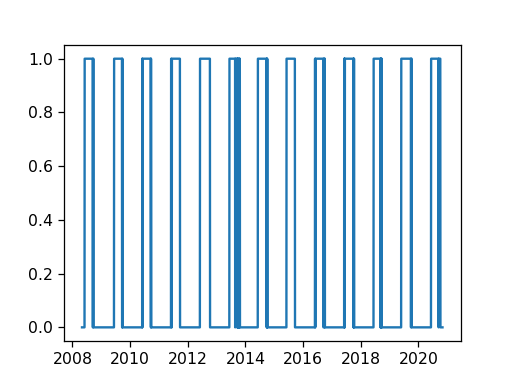

In [226]:



Daily['Freezing']=1
Daily.loc[Daily['Air_Temp']<1,'Freezing']=0

GS_Thresh = 0.25
Daily['Green']=1
Daily.loc[Daily['NDVI_FI_LCP']<GS_Thresh,'Green']=.5

Daily['Snow']=1
Daily.loc[Daily['NDSI_FI_LCP']>0,'Snow']=0
# Daily.loc[Daily['snow_cover']>50,'Snow']=0

Daily['Season']=0
Daily['Season'] = Daily['Snow']*Daily['Freezing']#*Daily['Green']#

for y in range(2008,2021):
    Year = Daily.loc[Daily.index.year==y].copy()
    Year['Season_Sum'] = Year['Season'].cumsum()
#     Year.loc[Year['Season_Sum']==0,'Season']=np.nan
#     Year.loc[((Year['Season_Sum']==Year['Season_Sum'].max())&
#               (Year['Season']==0)),'Season']=np.nan
#     Year.loc[Year['Season'].isnull()==False,'Season']=1
#     Year.loc[Year['Season']<0.5,'Season']=np.nan
    Daily.loc[Daily.index.year==y,'Season_Sum']=Year['Season_Sum']*1
    Daily.loc[Daily.index.year==y,'Season_Root']=Year['Season_Sum']**.5
    FDF.loc[FDF.index==y,'Season_Sum']=Year['Season_Sum'].max()
    FDF.loc[FDF.index==y,'Season_Root']=Year['Season_Sum'].max()**.5
    Daily.loc[Daily.index.year==y,'Season']=Year['Season']

FDF['Season_Root']=FDF['Season_Sum']**.5

# plt.figure(figsize=(4,3))
# plt.plot(Daily['Season'])


ALH=pd.read_csv(Output_Path+'AL_Depth.csv',header=[1])
AL=pd.read_csv(Output_Path+'AL_Depth.csv',skiprows=4)
AL.columns=ALH.columns
AL=AL.rename(columns={'Name':'Year'})
AL = AL.set_index('Year')

AL = AL[['Reindeer Depot  (Thaw tube)','Lousy Point (Thaw tube)']].dropna()

T = Daily.loc[Daily.index.year>=2008].resample('Y').mean()[['Air_Temp']]
T['Year']=T.index.year
T = T.set_index('Year')
AL = AL.join(T).join(FDF)#.join(Days)

C = ((AL.corr()).round(2)[['Reindeer Depot  (Thaw tube)','Lousy Point (Thaw tube)']][2:])
S = np.sign(C)#*10
C = S.multiply(C**2).round(3)
C[C.abs()<.3]=np.nan

# fig,ax=plt.subplots(2,figsize=(3,4))
# ax[0].scatter(AL['Reindeer Depot  (Thaw tube)'],AL['Season_Sum'])
# ax[1].scatter(AL['Lousy Point (Thaw tube)'],AL['Season_Sum'])

AL_s = 'Reindeer Depot  (Thaw tube)'
v = 'Season_Root'
# v = 'Season_Sum'
df = AL[[AL_s,v]].dropna()
Mod = LinearRegression()
Mod.fit(df[[AL_s]], df[v])
Test = Mod.predict(df[[AL_s]])
print('AL Comparisson')
print(AL_s)
print(metrics.r2_score(df[v],Test))

AL_s = 'Lousy Point (Thaw tube)'
df = AL[[AL_s,v]].dropna()
Mod = LinearRegression()
Mod.fit(df[[AL_s]], df[v])
Test = Mod.predict(df[[AL_s]])
print()
print(AL_s)
print(metrics.r2_score(df[v],Test))
print('Correlations')
print(C[C.isnull().sum(axis=1)<2])
AL = AL.loc[AL.index>=2008].copy()
# AL

Data[['Season','Green','Snow','Freezing']]=Daily.resample('H').bfill()[['Season','Green','Snow','Freezing']]
Data['Season_Sum']=Daily.resample('H').interpolate()['Season_Sum']
Data['Season_Root']=Data['Season_Sum']**.5

Data.loc[((Data.index.month<=4)|(Data.index.month>=11)),['Season','Season_Sum','Season_Root']]=np.nan
Data.loc[Data['Season'].isnull(),['Season_Sum','Season_Root']]=np.nan

for v in ['DOY','Season_Sum','Season_Root',]:
    for d in AL_obs.index.unique():
        AL_obs.loc[AL_obs.index==d,v]=Daily.loc[Daily.index.date==d,v].values[0]

y=['Active_Layer_1']
Y = 'AL_data_est'
Lag = []
D = []
K = 10

X = ['Season_Sum']
X = ['Season_Root']

Val,C,I,RMSE,R2 = Model_Test(X,y,AL_obs.copy(),K=K,Test = 'OLS',Task='Predict_Return')
AL_obs[Y]=Val

Daily['AL_data_est'] = (Daily[X[0]])*C+I
Data['AL_data_est'] = (Data[X[0]])*C+I

Daily.loc[Daily['AL_data_est']<=0,'AL_data_est']=np.nan

T = Daily.loc[Daily.index.year>=2008].resample('Y').max()[['AL_data_est']]
T['Year']=T.index.year
T = T.set_index('Year')
try:
    AL = AL.drop(columns='AL_data_est')
except:
    pass
AL = AL.join(T)
AL = AL.loc[AL['AL_data_est'].isnull()==False].copy()



AL Comparisson
Reindeer Depot  (Thaw tube)
0.6265522177636261

Lousy Point (Thaw tube)
0.5160808162549599
Correlations
             Reindeer Depot  (Thaw tube)  Lousy Point (Thaw tube)
Air_Temp                           0.740                    0.706
snow_cover                           NaN                   -0.314
Season_Sum                         0.624                    0.518
Season_Root                        0.624                    0.518

Active_Layer_1
RMSE 0.024739495318865774
std RMSE 0.005916449941067247
r2 0.9194368560108586
coef [0.04764108]
int 0.022525454289426962


Int64Index([154], dtype='int64')
DOY               0.962242
DSSM              0.962242
DSQ               0.948519
Active_Layer_1    1.000000
Name: Active_Layer_1, dtype: float64

Active_Layer_1
RMSE 0.020122979717434958
std RMSE 0.006195651834781046
r2 0.942449885478823
coef [0.00347315]
int 0.14913936238794465


Active_Layer_1
RMSE 0.023790357839345154
std RMSE 0.006010284795556424
r2 0.9237327176021665
coef [0.05116519]
int -0.025504044954352916


[-0.00247971]


<IPython.core.display.Javascript object>


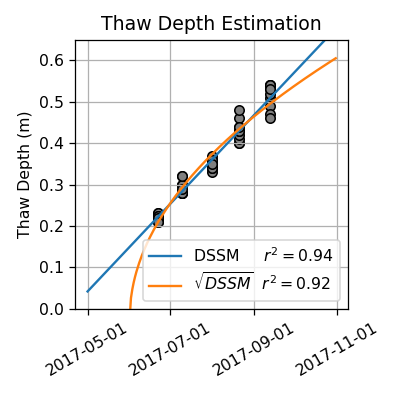

In [197]:
print(Data.loc[((Data.index.year == 2017)&(Data.Season == 1))][0:1].index.dayofyear)

AL_obs['DSSM'] = AL_obs['DOY']-152
AL_obs['DSQ'] = AL_obs['DSSM']**.5
# plt.errorbar(M.index,M['Active_Layer_1'],yerr=AL_obs.groupby('DOY').std()['Active_Layer_1'])
print(AL_obs[['DOY','DSSM','DSQ','Active_Layer_1']].corr()['Active_Layer_1']**2)
y = ['Active_Layer_1']
X = ['DSSM']
Val,C1,I1,MSE,R2 = Model_Test(X,y,AL_obs.copy(),K=K,Test = 'OLS',Task='Predict_Return')

Daily['DSSM'] = Daily.index.dayofyear-152
Sub = Daily.loc[((Daily.index.year==2017)&(Daily.Season>=0))]


print()
X = ['DSQ']
Val,C,I,MSE,R2 = Model_Test(X,y,AL_obs.copy(),K=K,Test = 'OLS',Task='Predict_Return')

print()
print()
print(C*0.45+I)

fig,ax=plt.subplots(figsize=(3.5,3.5)) 
plt.plot(Sub.index,Sub['DSSM']*C1+I1,label='DSSM     $r^2 = 0.94$')
plt.plot(Sub.index,(Sub['DSSM']**.5)*C+I,label='$\sqrt{DSSM}$  $r^2 = 0.92$')

plt.scatter(AL_obs.index, AL_obs['Active_Layer_1'],color='grey',edgecolor='k')
ax.set_title('Thaw Depth Estimation')
ax.legend(loc=4)
ax.set_xticks(l[::2])
ax.set_ylabel('Thaw Depth (m)')

plt.grid()
plt.ylim(0,0.65)
l = ax.get_xticks()

fig.autofmt_xdate(ha='center')
plt.tight_layout()
plt.savefig(G_Drive+'/PhD_Thesis/Chapter3_Figs/AL_fig.png',dpi=600)

# Snow Analysis

# Fill Params

# Sub-Surface Fill

In [20]:
# Data['Rolling_RainfallD14']=Data['Rainfall'].rolling(str(14)+'D').sum()
Data['Rolling_RainfallD6']=Data['Rainfall'].rolling(str(6)+'D').sum()
Data['Rolling_RainfallD3']=Data['Rainfall'].rolling(str(3)+'D').sum()
Data['Rolling_RainfallD']=Data['Rainfall'].rolling(str(1)+'D').sum()

# Data['Rolling_Air_Temp_D14']=Data['Air_Temp'].rolling(str(14)+'D').mean()
# Data['Rolling_Air_Temp_D6']=Data['Air_Temp'].rolling(str(6)+'D').mean()
Data['Rolling_Air_TempD3']=Data['Air_Temp'].rolling(str(3)+'D').mean()
Data['Rolling_Air_TempD']=Data['Air_Temp'].rolling(str(1)+'D').mean()

Data['Rolling_Air_TempH1']=Data['Air_Temp'].rolling(str(6)+'H').mean()
Data['Rolling_Air_TempH2']=Data['Air_Temp'].rolling(str(12)+'H').mean()
Data['Rolling_Air_TempH3']=Data['Air_Temp'].rolling(str(18)+'H').mean()

Y = 'Test'

SE_Rule = 2

Met = [
    'Net_SW',
    'Net_LW',
#     'Net_RN'
    'Air_Temp',
#     'Rainfall'
    ]
Lag_Rain = [
#     'Rolling_RainfallD6',
    'Rolling_RainfallD3',
#     'Rolling_RainfallD',
    ]
Lag_Air = [
    'Rolling_Air_TempH1',
    'Rolling_Air_TempH2',
    'Rolling_Air_TempH3',
    'Rolling_Air_TempD'
    ]
ERA5_Temp = [
    'soil_temperature_level_1',
    'soil_temperature_level_2',
    'soil_temperature_level_3'
    ]

ERA5_VWC = [
    'volumetric_soil_water_layer_1',
    'volumetric_soil_water_layer_2',
    ]

AllX = Met+Lag_Air+Lag_Rain+ERA5_Temp+ERA5_VWC
print(len(AllX))

Mods = {
}
for y in [['Temp_15_1'],['Temp_15_2'],['Temp_5_1'],['Temp_5_2'],['Table_1']]:
    X = AllX
    res = {
        'X':X,
        'Score':np.ones(len(X))/len(X)
    }
    Results = pd.DataFrame(data=res)
    K = 30
    Track = {'i':[],
            'Rem':[],
            'RMSE':[],
            'RMSES':[],
            'R2':[],
#             'R2S':[]
            }
    for i in range(len(X)):
        X = list(Results.X.values)
        Val,C,I,MSE,R2 = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],K=K,
                             Test = 'OLS',Scale=True,Task='Predict_Return',Verbose=False)
        MSE = np.array(MSE)**.5
        Results['Score'] = C**2/(C**2).sum()
        Results = Results.sort_values('Score')
        Rem = Results.loc[Results['Score']==Results['Score'].min(),'X'].values[0]
        Results = Results.loc[Results['Score']>Results['Score'].min()]
        Track['i'].append(len(X))
        Track['R2'].append(np.mean(np.array(R2)))
#         Track['R2S'].append(np.std(np.array(R2)))
        Track['RMSE'].append(MSE.mean())
        Track['RMSES'].append(MSE.std())#/(MSE.shape[0]**.5))
        Track['Rem'].append(Rem)

    Track = pd.DataFrame(data=Track)
    Track = Track.set_index('i')
    Track['RMSESS'] = (Track['RMSE'] + Track['RMSES']*SE_Rule)
#     Track['R2SS'] = (Track['R2'] - Track['R2S']*SE_Rule)
    Mods[y[0]] = {}
    Sel = Track.loc[Track['RMSE']<Track['RMSESS'].min(),['RMSE','RMSES','R2']][-1:]
#     Sel = Track.loc[Track['R2']/Track['R2'].max()>0.95,['RMSE','RMSES','R2']][-1:]
    M = Track.loc[Track.index<=Sel.index.values[0],'Rem'].values
    Mods[y[0]]['Stats']=Sel
    Mods[y[0]]['X']=M
    print(y)
    print(M)
    print()
    print(Sel)
#     print(Track)
    print()
    print()

13
['Temp_15_1']
['soil_temperature_level_2' 'volumetric_soil_water_layer_2'
 'soil_temperature_level_3' 'Air_Temp' 'Rolling_Air_TempH1' 'Net_SW'
 'Rolling_Air_TempH2' 'Rolling_Air_TempD' 'Rolling_Air_TempH3']

       RMSE     RMSES        R2
i                              
9  0.421864  0.017373  0.913586


['Temp_15_2']
['volumetric_soil_water_layer_2' 'Rolling_Air_TempH2' 'Rolling_Air_TempH3'
 'Rolling_Air_TempD' 'soil_temperature_level_3' 'Air_Temp'
 'Rolling_Air_TempH1' 'Net_SW']

       RMSE     RMSES        R2
i                              
8  0.472185  0.028897  0.891154


['Temp_5_1']
['Net_SW' 'soil_temperature_level_2' 'Rolling_Air_TempD'
 'soil_temperature_level_3' 'Rolling_Air_TempH3' 'Rolling_Air_TempH2'
 'Air_Temp' 'Rolling_Air_TempH1']

       RMSE     RMSES        R2
i                              
8  0.722865  0.027237  0.906771


['Temp_5_2']
['Net_LW' 'soil_temperature_level_1' 'Air_Temp' 'Rolling_Air_TempH1'
 'Rolling_Air_TempD' 'Rolling_Air_TempH3' 'Rolling_Air_Te

In [21]:
# print(Track['R2']/Track['R2'].max()>0.95)

# print(Data['Season'])

<IPython.core.display.Javascript object>


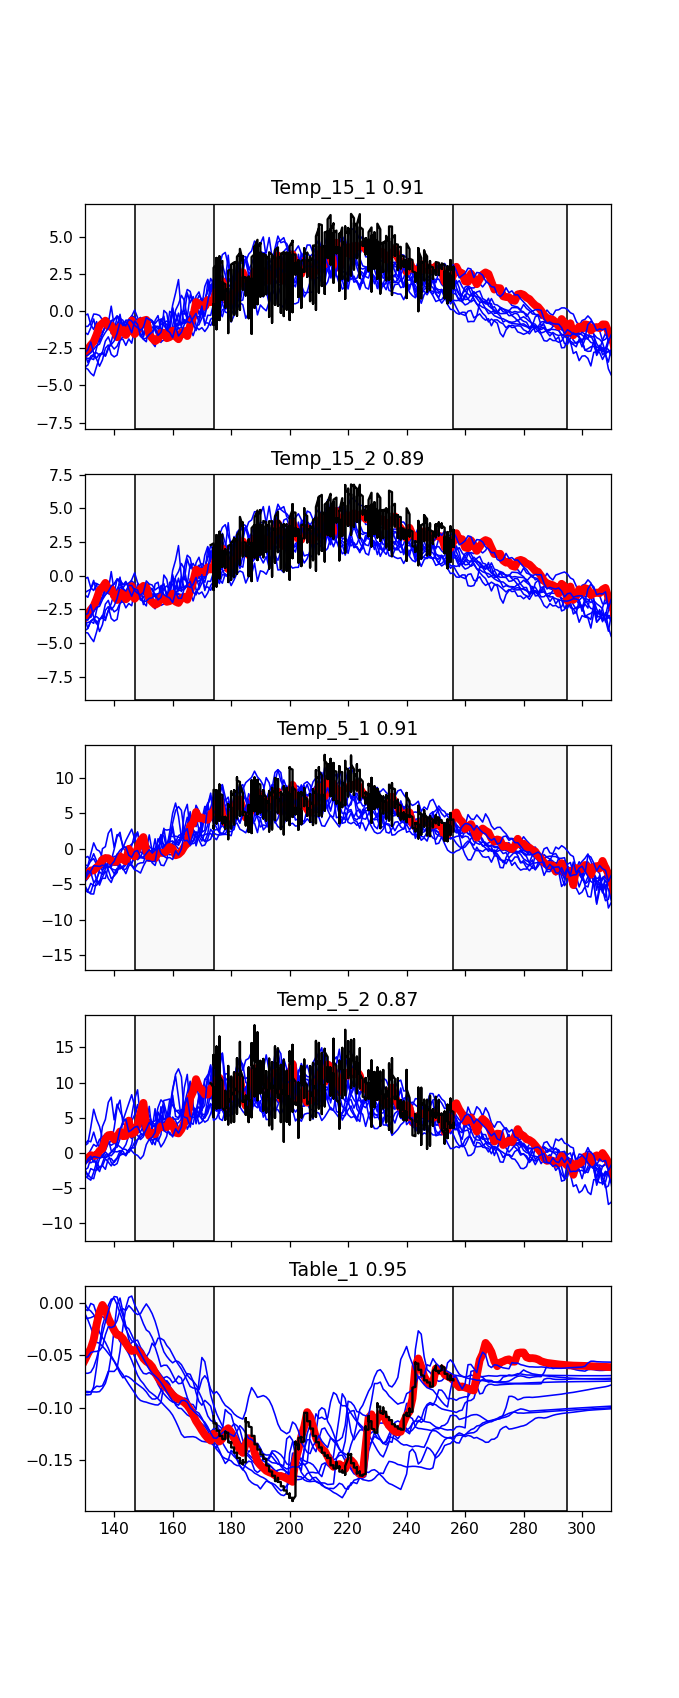

       RMSE     RMSES        R2
i                              
9  0.421864  0.017373  0.913586

r2:  0.9154535680166923
RMSE:  0.4201197432847053
       RMSE     RMSES        R2
i                              
8  0.472185  0.028897  0.891154

r2:  0.8930152939231452
RMSE:  0.4707782242653458
       RMSE     RMSES        R2
i                              
8  0.722865  0.027237  0.906771

r2:  0.908636185126631
RMSE:  0.7197915063359053
       RMSE     RMSES        R2
i                              
7  1.169391  0.051049  0.874523

r2:  0.8776341926932772
RMSE:  1.163050880262077
       RMSE     RMSES        R2
i                              
4  0.007089  0.000468  0.952754

r2:  0.9537124568529606
RMSE:  0.007082225579817953


In [22]:
fig,ax=plt.subplots(len(Mods.keys()),sharex=True,figsize=(6,len(Mods.keys())*3))
j = 0
for Y in Mods.keys():
#     print(Mods[y]['X'])
    X = list(Mods[Y]['X'])
    y = [Y]
    print(Mods[Y]['Stats'])
    Val = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],
                                K=K,Test = 'OLS',Scale=True,Task='Predict',Verbose=False)
    Data[Y+'_OLS']=np.nan
    Data.loc[~Data[X].T.isnull().any(),Y+'_OLS']=Val
                     
    DNA = Data[y+[Y+'_OLS']].dropna()
    print()
    print('r2: ',metrics.r2_score(DNA[y],DNA[Y+'_OLS']))
    print('RMSE: ',metrics.mean_squared_error(DNA[y],DNA[Y+'_OLS'])**.5)


    for y in range(2009,2020):
        Yr = Data.loc[Data.index.year==y].resample('D').mean()
        if y == 2017:
            ax[j].plot(Yr['DOY'],Yr[Y+'_OLS'],color='r',linewidth=5)
        else:
            ax[j].plot(Yr['DOY'],Yr[Y+'_OLS'],color='b',linewidth=1)
    ax[j].plot(Data['DOY'],Data[Y],color='k')
    ax[j].set_title(Y+' '+ str(Mods[Y]['Stats']['R2'].round(2).values[0]))


    ax[j].axvspan(147,174,facecolor=[.97,.97,.97,.65],edgecolor='k')
    ax[j].axvspan(256,295,facecolor=[.97,.97,.97,.65],edgecolor='k')
    ax[j].set_xlim(130,310)
    j +=1

In [48]:
Y = 'Test'
# SE_Rule = 2
Met = [
    'Net_LW',
    'Net_SW',
    'Wind_Speed',
    'Air_Temp',
#     'Rainfall'
    ]
ERA5_Met = [
    'temperature_2m',
    'dewpoint_temperature_2m',
    'Wind_10m',
    'HH',
    ]
AllX = Met+ERA5_Met
print(len(AllX))
Mods = {}
for y in [['u*'],['PPFD_Avg'],['VPD']]:
    X = AllX
    res = {
        'X':X,
        'Score':np.ones(len(X))/len(X)
    }
    Results = pd.DataFrame(data=res)
    K = 30
    Track = {'i':[],
            'Rem':[],
            'RMSE':[],
            'RMSES':[],
             'Int':[],
             'Coef':[],
            'R2':[],
            'R2S':[]}
    for i in range(len(X)):
        X = list(Results.X.values)
        Val,C,I,MSE,R2 = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],K=K,
                             Test = 'OLS',Scale=True,Task='Predict_Return',Verbose=False)
        MSE = np.array(MSE)**.5
        Results['Score'] = C**2/(C**2).sum()
        Results = Results.sort_values('Score')
        Rem = Results.loc[Results['Score']==Results['Score'].min(),'X'].values[0]
        Results = Results.loc[Results['Score']>Results['Score'].min()]
        Track['i'].append(len(X))
        Track['Int'].append(np.mean(np.array(I)))
        Track['Coef'].append(np.mean(np.array(C)))
        Track['R2'].append(np.mean(np.array(R2)))
        Track['R2S'].append(np.std(np.array(R2)))
        Track['RMSE'].append(MSE.mean())
        Track['RMSES'].append(MSE.std())#/(MSE.shape[0]**.5))
        Track['Rem'].append(Rem)

    Track = pd.DataFrame(data=Track)
    Track = Track.set_index('i')
    Track['RMSESS'] = (Track['RMSE'] + Track['RMSES']*SE_Rule)
    Track['R2SS'] = (Track['R2'] - Track['R2S']*SE_Rule)
    Mods[y[0]] = {}
    Sel = Track.loc[Track['RMSE']<Track['RMSESS'].min(),['RMSE','RMSES','R2','R2S','Coef','Int']][-1:]
#     Sel = Track.loc[Track['R2']/Track['R2'].max()>0.95,['RMSE','RMSES','R2']][-1:]
    M = Track.loc[Track.index<=Sel.index.values[0],'Rem'].values
    Mods[y[0]]['Stats']=Sel
    Mods[y[0]]['X']=M
    print(y)
    print(M)
    print(Sel)
#     print(Track)
    print()

8
['u*']
['Wind_Speed']
       RMSE     RMSES       R2       R2S      Coef       Int
i                                                           
1  0.045001  0.003854  0.89794  0.017879  0.135016  0.304448

['PPFD_Avg']
['Net_SW']
        RMSE     RMSES       R2       R2S        Coef         Int
i                                                                
1  38.631624  2.556721  0.99004  0.001961  389.665438  333.846646

['VPD']
['dewpoint_temperature_2m' 'Air_Temp']
         RMSE    RMSES        R2       R2S        Coef         Int
i                                                                 
2  143.640976  6.59898  0.837683  0.025646  119.975823  287.774113



In [47]:
X = ['Wind_Speed']
y = ['u*']
Val,C,I,MSE,R2 = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],K=K,
                     Test = 'OLS',Scale=False,Task='Predict_Return',Verbose=True)

X = ['Net_SW']
y = ['PPFD_Avg']
Data['Net_SW_T'] = Data['Net_SW'].copy()
Data.loc[Data['Net_SW_T']<0,'Net_SW_T']=0
Val,C,I,MSE,R2 = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],K=K,
                     Test = 'OLS',Scale=False,Task='Predict_Return',Verbose=True)


u*
RMSE 0.04500149440521988
std RMSE 0.0038542468485703867
r2 0.8948652491619089
coef [0.07370356]
int 0.021367641498866184

PPFD_Avg
RMSE 38.63162448677514
std RMSE 2.5567209462702647
r2 0.9904007390827857
coef [2.38028641]
int 3.848866329466529


<IPython.core.display.Javascript object>


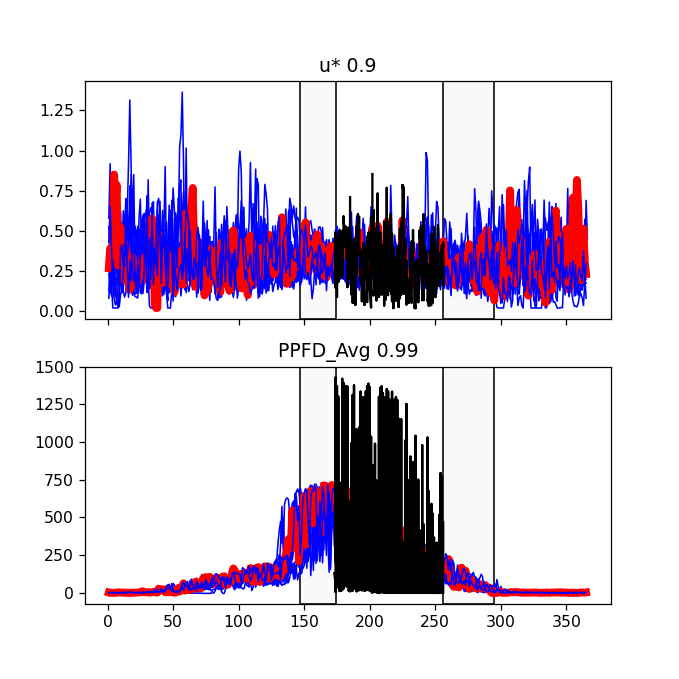

       RMSE     RMSES       R2       R2S      Coef       Int
i                                                           
1  0.045001  0.003854  0.89794  0.017879  0.135016  0.304448

u*
RMSE 0.04500149440521988
std RMSE 0.0038542468485703893
r2 0.8948652491619089
coef [0.13501616]
int 0.3044481420598676

r2:  0.8998657373147907
RMSE:  0.045041291088142706
        RMSE     RMSES       R2       R2S        Coef         Int
i                                                                
1  38.631624  2.556721  0.99004  0.001961  389.665438  333.846646

PPFD_Avg
RMSE 38.63162448677515
std RMSE 2.556720946270257
r2 0.9904007390827857
coef [389.66543789]
int 333.84664621212124

r2:  0.990258864514813
RMSE:  38.64921631423895


In [35]:
fig,ax=plt.subplots(len(Mods.keys()),sharex=True,figsize=(6,len(Mods.keys())*3))
j = 0
for Y in Mods.keys():
#     print(Mods[y]['X'])
    X = list(Mods[Y]['X'])
    y = [Y]
    print(Mods[Y]['Stats'])
    Val = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],
                                K=K,Test = 'OLS',Scale=True,Task='Predict',Verbose=True)
    Data[Y+'_OLS']=np.nan
    Data.loc[~Data[X].T.isnull().any(),Y+'_OLS']=Val
                     
    DNA = Data[y+[Y+'_OLS']].dropna()
    print()
    print('r2: ',metrics.r2_score(DNA[y],DNA[Y+'_OLS']))
    print('RMSE: ',metrics.mean_squared_error(DNA[y],DNA[Y+'_OLS'])**.5)


    for y in range(2009,2020):
        Yr = Data.loc[Data.index.year==y].resample('D').mean()
        if y == 2017:
            ax[j].plot(Yr['DOY'],Yr[Y+'_OLS'],color='r',linewidth=5)
        else:
            ax[j].plot(Yr['DOY'],Yr[Y+'_OLS'],color='b',linewidth=1)
    ax[j].plot(Data['DOY'],Data[Y],color='k')
    ax[j].set_title(Y+' '+ str(Mods[Y]['Stats']['R2'].round(2).values[0]))
    
    ax[j].axvspan(147,174,facecolor=[.97,.97,.97,.65],edgecolor='k')
    ax[j].axvspan(256,295,facecolor=[.97,.97,.97,.65],edgecolor='k')
    j +=1

<IPython.core.display.Javascript object>


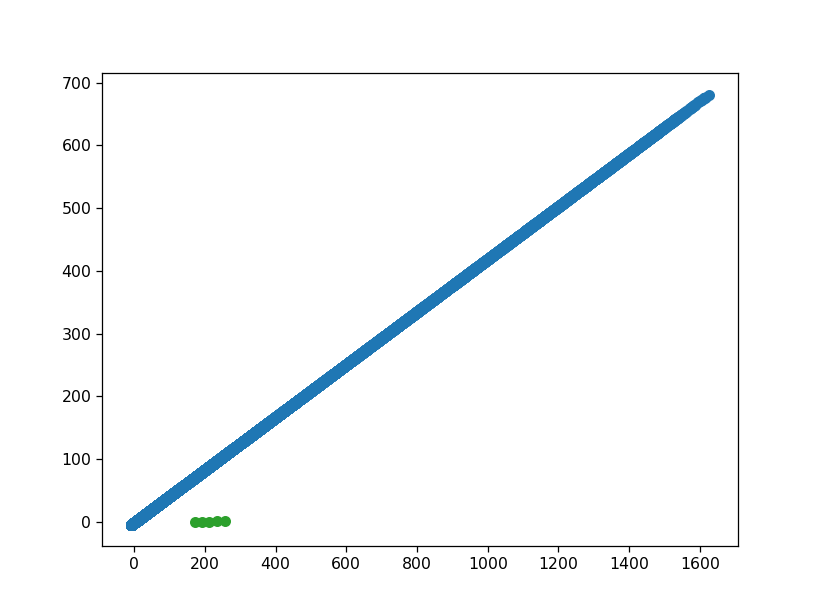

In [36]:
plt.figure()
plt.scatter(Data['PPFD_Avg_OLS'],Data['Net_SW'])

In [25]:
Data['Rolling_Rainfall_D14']=Data['Rainfall'].rolling(str(14)+'D').sum()
Data['Rolling_Rainfall_D6']=Data['Rainfall'].rolling(str(6)+'D').sum()
Data['Rolling_Rainfall_D3']=Data['Rainfall'].rolling(str(3)+'D').sum()
Data['Rolling_Rainfall_D']=Data['Rainfall'].rolling(str(1)+'D').sum()

Data['Rolling_Air_Temp_D3']=Data['Air_Temp'].rolling(str(3)+'D').mean()
Data['Rolling_Air_Temp_D']=Data['Air_Temp'].rolling(str(1)+'D').mean()

Data['Rolling_Air_TempH1']=Data['Air_Temp'].rolling(str(6)+'H').mean()
Data['Rolling_Air_TempH2']=Data['Air_Temp'].rolling(str(12)+'H').mean()
Data['Rolling_Air_TempH3']=Data['Air_Temp'].rolling(str(18)+'H').mean()

Y = 'Test'

# SE_Rule = 2

Met = [
    
    'Air_Temp',
#     'Rainfall'
    ]
ERA5_Met = [
    'temperature_2m',
    'dewpoint_temperature_2m',
    'W_Dir_ERA5',
#     'Wind_10m',
#     'HH',
    ]


AllX = Met+ERA5_Met
print(len(AllX))

Mods = {
}
for y in [['VPD']]:
    X = AllX
    res = {
        'X':X,
        'Score':np.ones(len(X))/len(X)
    }
    Results = pd.DataFrame(data=res)
    K = 10
    Track = {'i':[],
            'Rem':[],
            'RMSE':[],
            'RMSES':[],
            'R2':[],
            'R2S':[]}
    for i in range(len(X)):
        X = list(Results.X.values)
        Val,C,MSE,R2 = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],K=K,
                             Test = 'RF',Task='Predict_Return',Verbose=False,min_samples_split=2)
        MSE = np.array(MSE)**.5
        Results['Score'] = C#/C.sum()
        Results = Results.sort_values('Score')
        Rem = Results.loc[Results['Score']==Results['Score'].min(),'X'].values[0]
        Results = Results.loc[Results['Score']>Results['Score'].min()]
        Track['i'].append(len(X))
        Track['R2'].append(np.mean(np.array(R2)))
        Track['R2S'].append(np.std(np.array(R2)))
        Track['RMSE'].append(MSE.mean())
        Track['RMSES'].append(MSE.std())#/(MSE.shape[0]**.5))
        Track['Rem'].append(Rem)

    Track = pd.DataFrame(data=Track)
    Track = Track.set_index('i')
    Track['RMSESS'] = (Track['RMSE'] + Track['RMSES']*SE_Rule)
    Track['R2SS'] = (Track['R2'] - Track['R2S']*SE_Rule)
    Mods[y[0]] = {}
    Sel = Track.loc[Track['RMSE']<Track['RMSESS'].min(),['RMSE','RMSES','R2','R2S']][-1:]
#     Sel = Track.loc[Track['R2']/Track['R2'].max()>0.95,['RMSE','RMSES','R2']][-1:]
    M = Track.loc[Track.index<=Sel.index.values[0],'Rem'].values
    Mods[y[0]]['Stats']=Sel
    Mods[y[0]]['X']=M
    print(y)
    print(M)
    print(Sel)
    print(Track)
    
    print()

4
['VPD']
['temperature_2m' 'dewpoint_temperature_2m' 'Air_Temp']
         RMSE      RMSES        R2      R2S
i                                          
3  109.436241  10.164922  0.904358  0.02754
                       Rem        RMSE      RMSES        R2       R2S  \
i                                                                       
4               W_Dir_ERA5  100.594252   9.684403  0.919030  0.024542   
3           temperature_2m  109.436241  10.164922  0.904358  0.027540   
2  dewpoint_temperature_2m  120.150011   8.067814  0.884951  0.029899   
1                 Air_Temp  169.981249   7.801545  0.770562  0.047739   

       RMSESS      R2SS  
i                        
4  119.963059  0.869946  
3  129.766086  0.849278  
2  136.285639  0.825153  
1  185.584338  0.675084  



<IPython.core.display.Javascript object>


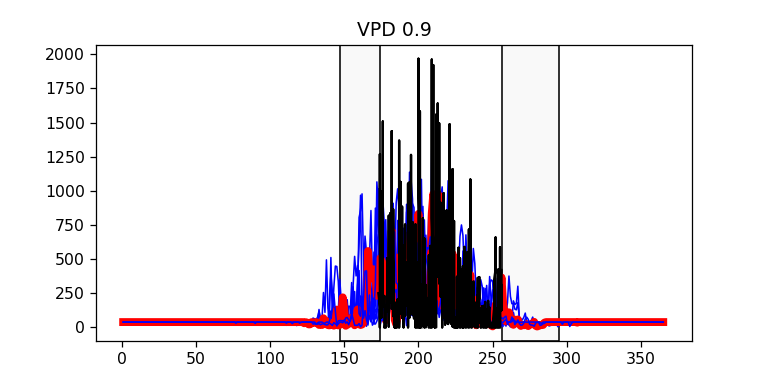

         RMSE      RMSES        R2      R2S
i                                          
3  109.436241  10.164922  0.904358  0.02754

r2:  0.9833208568058639
RMSE:  46.66432039271478


In [26]:
fig,ax=plt.subplots(len(Mods.keys()),sharex=True,figsize=(6,len(Mods.keys())*3))
if len(Mods.keys())==1:
    ax = [ax]
j = 0
for Y in Mods.keys():
#     print(Mods[y]['X'])
    X = list(Mods[Y]['X'])
    y = [Y]
    print(Mods[Y]['Stats'])
    Val = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],
                                K=K,Test = 'RF',Scale=True,Task='Predict',Verbose=False,min_samples_split=2)
    Data[Y+'_RF']=np.nan
    Data.loc[~Data[X].T.isnull().any(),Y+'_RF']=Val
                     
    DNA = Data[y+[Y+'_RF']].dropna()
    print()
    print('r2: ',metrics.r2_score(DNA[y],DNA[Y+'_RF']))
    print('RMSE: ',metrics.mean_squared_error(DNA[y],DNA[Y+'_RF'])**.5)


    for y in range(2009,2020):
        Yr = Data.loc[Data.index.year==y].resample('D').mean()
        if y == 2017:
            ax[j].plot(Yr['DOY'],Yr[Y+'_RF'],color='r',linewidth=5)
        else:
            ax[j].plot(Yr['DOY'],Yr[Y+'_RF'],color='b',linewidth=1)
    ax[j].plot(Data['DOY'],Data[Y],color='k')
    ax[j].set_title(Y+' '+ str(Mods[Y]['Stats']['R2'].round(2).values[0]))


    ax[j].axvspan(147,174,facecolor=[.97,.97,.97,.65],edgecolor='k')
    ax[j].axvspan(256,295,facecolor=[.97,.97,.97,.65],edgecolor='k')
    j +=1

# WX Summary Stats


In [27]:
# print(AL.columns)
# print(AL[['Peak_Day','Peak_Height','Peak_NDVI']].corr()**2)
# print(AL[['Peak_Day_BL','Peak_Height_BL']].corr()**2)
# print(AL[['Peak_Height_BL','Peak_Height']].corr()**2)
# print()
# print(AL['Peak_NDVI'].median())
# # print(np.round(AL['Peak_Height'].max()-AL['Peak_Height'].min(),2))
# # print(np.round(AL['Peak_Height'].max()-AL['Peak_Height'].min(),2))

# print(AL['Start_Day'])
# AL['Peak_Date'] = pd.to_datetime(AL.index * 1000 + AL['Peak_Day'], format='%Y%j')
# AL['Peak_Date_BL'] = pd.to_datetime(AL.index * 1000 + AL['Peak_Day_BL'], format='%Y%j')
# AL['Start_Date'] = pd.to_datetime(AL.index * 1000 + AL['Start_Day'], format='%Y%j')
# AL['End_Date'] = pd.to_datetime(AL.index * 1000 + AL['End_Day'], format='%Y%j')
# Yrly = AL[['Peak_Height','Peak_Date','Peak_Date_BL','Peak_Height',]]#.sort_values(by='Season_Sum')
# print(Yrly)
# Yrly = AL[['Start_Date','End_Date','Season_Sum']].reset_index(drop=True)#.sort_values(by='Season_Sum').reset_
# print(Yrly)
# 

In [28]:
# print(Daily)
Daily = Data.resample('D').mean()
Daily = Daily[Daily['Air_Temp'].isnull()==False]
# Daily.loc[Daily.index.year == 2009]

In [29]:
# # fig,ax = plt.subplots(figsize=(4,3.25))
# fig,((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

# C = [
# '#b2182b',
# '#d6604d',
# '#f4a582',
# '#fddbc7',
# '#383838',
# '#d1e5f0',
# '#92c5de',
# '#4393c3',
# '#2166ac',
# ][::-1]
# I = 0
# # %matplotlib notebook

# # Daily = Data.resample('Y').mean()
# # Daily

# Daily['Warm']=np.nan
# Daily.loc[Daily['Air_Temp']>0,'Warm']=1

# Study_Years = {'Year':[],
#               'Warm_Days':[],
#               'Warm_First':[],
#               'Warm_Last':[]}

# for y in Yrly.index[::-1]:
#     Fy=Flood.loc[Flood.index.year==y].copy()
#     YR = Daily.loc[Daily.index.year==y].copy()
# #     for s in ['KULUARPAK']:
#     if Fy['KULUARPAK'].count()/(1464/24)>.8:
#         ax.plot(Fy.index.dayofyear,Fy['KULUARPAK'],color=C[I],label=str(int(y)))
#         ax2.plot(Fy.index.dayofyear,Fy['NDVI_interp'].diff().abs(),color=C[I],label=str(int(y)))
        
#         I += 1

#     if y != 2008:
#         Study_Years['Year'].append(y)
#         Study_Years['Warm_Last'].append((YR['Warm']*YR['DOY']).max())
#         Study_Years['Warm_First'].append((YR['Warm']*YR['DOY']).min())
#         YR['Warm']=YR['Warm'].fillna(0)
#         YR['Warm_Days']=YR['Warm'].cumsum()
#         Study_Years['Warm_Days'].append(YR['Warm_Days'].max())
#         ax3.plot(YR.index.dayofyear,YR['Warm_Days'])
#     ax4.plot(YR.index.dayofyear,YR['NDSI_interp'])

        
# Study_Stats = pd.DataFrame(data=Study_Years).sort_values(by='Year')
# print(Study_Stats)
# # ax3.bar(Study_Stats['Year'],Study_Stats['Warm_Last']-Study_Stats['Warm_First'],bottom=Study_Stats['Warm_First'])
# # ax3.bar(Study_Stats['Year'],Study_Stats['Warm_Days'])
# Save_Plots='C:\\Users\\User\\Google Drive\\PhD_Thesis\\Chapter3_Figs/'
# ax.legend(ncol=2,handlelength=1.5,columnspacing=1,fontsize=8)
# ax.set_ylim([8.5,10.4])
# ax.set_xlim(121,179)
# ax.grid()
# ax.set_ylabel('Gauge Height')
# ax.set_xlabel('Day of Year')
# ax.set_title('Kuluarpak Station Gauge Heights')
# # ax.set_xticks()
# plt.tight_layout()
# # plt.savefig(Save_Plots+'Gauge.png',dpi=600,bbox_inches='tight', pad_inches=0.05)

# Outputs

In [30]:
cols =['fch4','fco2','ch4_flux','co2_flux','Air_Temp','Rainfall','Wind_Speed','Wind_Direction',
        'Net_SW','Net_LW','Net_RN','Daytime','temperature_2m','dewpoint_temperature_2m',
       'volumetric_soil_water_layer_1','volumetric_soil_water_layer_2',
#        'volumetric_soil_water_layer_3',
#        'volumetric_soil_water_layer_4',
       'soil_temperature_level_1','soil_temperature_level_2',
       'soil_temperature_level_3',#'soil_temperature_level_4',
       'DOY',
       'NDSI_FI_LCP','NDVI_FI_LCP','GPP_FI_LCP',
       'snow_cover',
#        'NDSI_interp','GPP_interp','NDVI_interp',
       'Polygon','Rim','Polygon_Obs',
       'Rim_Obs',
       'VPD_RF',
       'Wind_Speed',
      'Net_RN',
       'Temp_5_1_OLS',
       'Temp_15_2_OLS',
       'Temp_15_1_OLS',
       'Temp_5_2_OLS',
       'VPD_RF',
       'PPFD_Avg_OLS',
       'u*_OLS',
       'Table_1_OLS',
       'AL_data_est',
       'Freezing','Green','Snow',
#        'Ts_15_1_OLS','Ts_5_1_OLS,','Ts_15_2_OLS','Ts_5_2_OLS',#'VPD_OLS',
#        'PPFD_AWS_RF','u*_est_RF','WTD_RF','AL_data_est_RF',
       'NEE_FSO','NME_FSO','Season_Sum','Season_Root',#'Season_Sum2',
       'Season',#,'Season2','Season3',
      'Daytime',
      ]

RN = {'Wind_Speed':'wind_speed',
      'Net_RN':'NR_Wm2_Avg',
       'Temp_5_1_OLS':'Temp_5_1',
       'Temp_15_2_OLS':'Temp_15_2',
       'Temp_15_1_OLS':'Temp_15_1',
       'Temp_5_2_OLS':'Temp_5_2',
       'VPD_RF':'VPD',
       'PPFD_Avg_OLS':'PPFD_Avg',
       'u*_OLS':'u*',
       'Table_1_OLS':'Table_1',
       'AL_data_est':'Active_Layer_1',
     }


# 58.8%	25.6%

Data['Polygon_Obs'] = Data['Polygon'].copy()
# Data['Polygon']=Data['Polygon'].median()
Data['Polygon'] = 0.588 # ALF derrived values
Data['Rim_Obs'] = Data['Rim'].copy()
# Data['Rim']=Data['Rim'].median()
Data['Polygon'] = 0.256 # ALF derrived values


for col in RN:
#     print(columns)
    Data[RN[col]+'_FO'] = Data[RN[col]].copy()
    Data[RN[col]+'_Diff'] = Data[RN[col]+'_FO']-Data[col]
    cols.append(RN[col]+'_FO')
    cols.append(RN[col]+'_Diff')

# Path = 'G:/My Drive/FishIsland_Outputs/Network_Outputs/Arctic_Sci_8Vars/'
    
Export = Data.copy()
Export.index.name = 'datetime'
Export.index = Export.index.tz_localize(None)
Export = Export.loc[((Export.index.month>=5)&(Export.index.month<=10))]
# Export[cols].rename(columns=RN).to_csv(Output_Path+'Network_Outputs/Arctic_Sci_8Vars/AWS_FI_Test.csv')
Export[cols].rename(columns=RN).to_csv(Output_Path+'Network_Outputs/Arctic_Sci_8Vars/AWS_FI_Final.csv')
# Export[cols].rename(columns=RN).to_csv('C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/AWS_FI_Test.csv')
print('Done')

Done


Polygon    0.256000
Rim        0.241664
dtype: float64


<IPython.core.display.Javascript object>


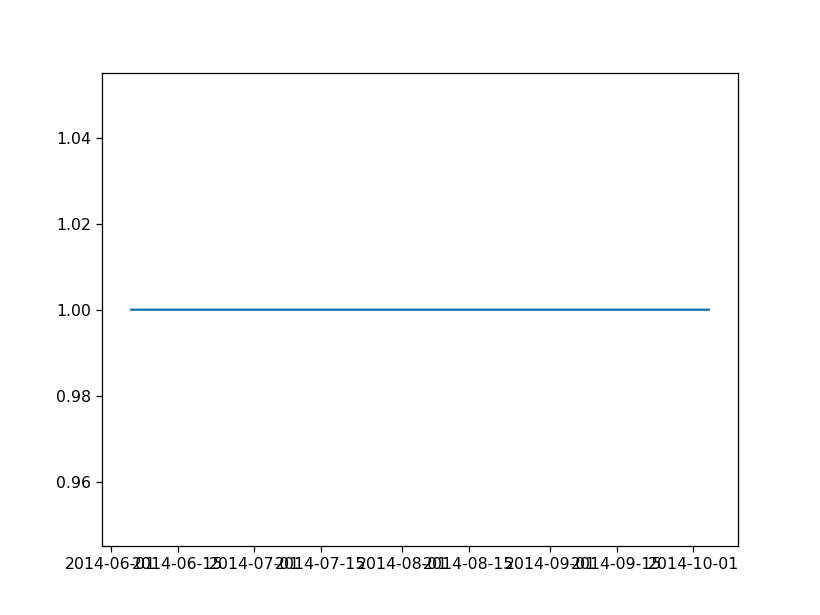

In [31]:
print(Data[['Polygon','Rim']].mean())
plt.figure()
plt.plot(Data.loc[Data.index.year==2014,'Season'])